# Data generation notebook for retail stock and supply chain - version 2

The data used in the retail stock optimization usecase is from the famous Kaggle dataset - olist_ecommerce by the Brazilian company olist. The data from olist is complete with matching products, suppliers, orders and such. Any data generation done needs to ensure that the IDs are not replaced as the data will lose its referential integrity

The scope of this data generation is restricted to the version 2 - multi-agent/autonomous-agents retail stock optimization solution, and will reuse data from the version 1 solution where possible. Version 2 features a set of brick and mortar stores (ecommerce data converted to POS data) and also features supply chain



In [1]:
project_id = "solution-workspace"
region = "us-central1"

In [ ]:
!pip install faker

In [ ]:
import pandas as pd, pandas_gbq
from faker import Faker
import uuid

## 1. Generate customers

### 1.1. Seed the customer IDs from olist source


Here, I am reusing the customer IDs from the sales_orders table but generating all other customder details.



In [ ]:
%%bigquery

--Create staging table
CREATE OR REPLACE table
rscw_stg.customer_master(
customer_id string,
first_nm string,
last_nm string,
email string,
address string,
city string,
state_cd string,
zip_cd string,
country_cd string,
phone_nbr string
);

--Scope out only those customer_ids that have orders from the past
insert into rscw_stg.customer_master(customer_id)
select distinct customer_id from olist_3nf.sales_orders;

### 1.2. Function to generate customers

In [ ]:
# For random assignment of cities
def get_location(counter):
  if(counter==1):
    desired_city="Naperville"
    desired_state_cd="IL"
    desired_zip_cd="60585"
  elif(counter==2):
    desired_city="Aurora"
    desired_state_cd="IL"
    desired_zip_cd="60502"
  elif(counter==3):
    desired_city="Schaumburg"
    desired_state_cd="IL"
    desired_zip_cd="60194"
  elif(counter==4):
    desired_city="Hinsdale"
    desired_state_cd="IL"
    desired_zip_cd="60521"
  elif(counter==5):
    desired_city="Chicago"
    desired_state_cd="IL"
    desired_zip_cd="60095"

  return desired_city,desired_state_cd,desired_zip_cd


In [ ]:
# Generate customers
def generate_customers():
  fake_customers = []
  fake = Faker('en_US')

  sql = "select customer_id from rscw_stg.customer_master"

  df = pandas_gbq.read_gbq(
      sql,
      project_id=project_id,
      dialect='standard',
  )

  location_counter=1
  desired_city,desired_state_cd,desired_zip_cd=get_location(location_counter)

  for index, row in df.iterrows():

    if ((index + 1) % 19888 == 0 and index < 99439):
       location_counter+=1
       desired_city,desired_state_cd,desired_zip_cd=get_location(location_counter)


    customer_id = row['customer_id']
    first_nm=fake.first_name()
    last_nm=fake.last_name()
    fake_customers.append({
        'customer_id': customer_id,
        'first_nm': first_nm,
        'last_nm': last_nm,
        'email': f"{first_nm.lower()}.{last_nm.lower()}@{fake.domain_name()}",
        'address': fake.street_address(),
        'city': desired_city,
        'state_cd': desired_state_cd,
        'zip_cd': desired_zip_cd,
        'country_cd': 'USA',
        'phone_nbr': fake.numerify(text='(###) ###-####')
        })

  df = pd.DataFrame(fake_customers)
  pandas_gbq.to_gbq(df, "rscw_stg.customer_master", project_id=project_id, if_exists="replace")
  return "Persisted customers to BigQuery"


### 1.3. Generate customers and persist to BigQuery staging table

In [ ]:
table_id = "rscw_stg.customer_master" # output table

try:
  generate_customers()

except Exception as e:
    print(f"Error writing results to BQ {table_id}. Error:", e)

#### 1.4. Perist to the main dataset

In [ ]:
%%bigquery
--Copy from staging to the main table
create or replace table rscw_ds.customer_master
as
select * from rscw_stg.customer_master;

select count(*) from rscw_ds.customer_master;--99441

In [ ]:
%%bigquery

select * from rscw_ds.customer_master limit 10;

In [ ]:
%%bigquery

--customers with purchases
select count(*) as customer_count from rscw_ds.customer_master where customer_id in (select distinct customer_id from rscw_ds.pos_transactions) --90644 buying customers out of 99441 in the customer master table

Downloading: 100%|██████████|


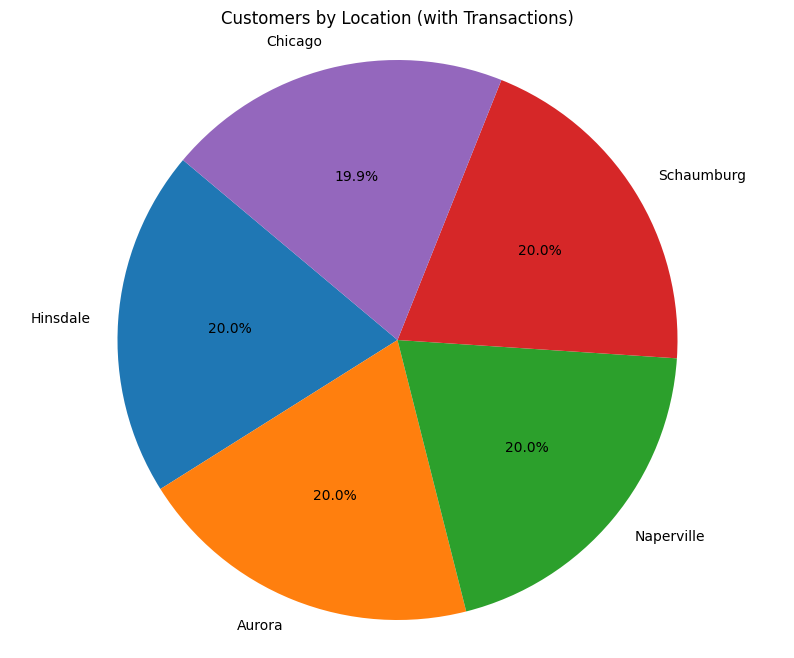

In [13]:
# prompt: show me customers by location in rscw_ds.customer_master table that exist in the rscw_ds.post_transactions table - render as pie chart

import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt

# SQL query to get customer locations for customers who have made transactions
sql = """
SELECT
    cm.city,
    COUNT(DISTINCT cm.customer_id) AS customer_count
FROM
    `solution-workspace.rscw_ds.customer_master` AS cm
JOIN
    `solution-workspace.rscw_ds.pos_transactions` AS pt
ON
    cm.customer_id = pt.customer_id
GROUP BY
    cm.city
ORDER BY
    customer_count DESC
"""

# Read data from BigQuery
df_customers_by_location = pandas_gbq.read_gbq(sql, project_id, dialect="standard")

# Render as a pie chart
plt.figure(figsize=(10, 8))
plt.pie(df_customers_by_location['customer_count'], labels=df_customers_by_location['city'], autopct='%1.1f%%', startangle=140)
plt.title('Customers by Location (with Transactions)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 2. Copy product master data

In [ ]:
%%bigquery

CREATE OR REPLACE table
rscw_ds.product_master as
select p.product_id, p.product_name as product_nm, p.category_id, c.category_name as category_nm, p.height_cm, p.length_cm, p.weight_cm as width_cm, p.weight_g, p.price_dollar, 0.0 as safety_qty
from olist_3nf.products p join
`solution-workspace.olist_3nf.product_categories` c on p.category_id = c.category_id
;

--Add gaming consoles
insert into rscw_ds.product_master(product_id, product_nm, category_id, category_nm, price_dollar, safety_qty) values('a1b39735-c79a-436a-97ca-b1310105f7b7','Elysium 2','b2d10450920f4ca39b4abb6f36c3068c', 'gaming',749.99,50);
insert into rscw_ds.product_master(product_id, product_nm, category_id, category_nm, price_dollar, safety_qty) values('88198bcc-4c2a-4532-a306-71ee9962dfd8','PlayStation 5','b2d10450920f4ca39b4abb6f36c3068c', 'gaming',799.99,50);
insert into rscw_ds.product_master(product_id, product_nm, category_id, category_nm, price_dollar, safety_qty) values('63796fad-02d3-45a3-908a-68c3cdeebb5d','Xbox Series X','b2d10450920f4ca39b4abb6f36c3068c', 'gaming',646.99,50);

--Add safety quanities into this table instead of separate table
MERGE INTO `rscw_ds.product_master` AS PM
USING (
    SELECT
        distinct product_id,
        safety_qty
    FROM `olist_3nf.stock_safety_quantities`
) AS S
ON PM.product_id = S.product_id
WHEN MATCHED THEN
    UPDATE SET safety_qty = S.safety_qty;


select count(*) from rscw_ds.product_master --32321



## 3. Copy supplier data

In [ ]:
%%bigquery

CREATE OR REPLACE table
rscw_ds.supplier_master as
select distinct supplier_id, supplier_name as supplier_nm, s.contact_name as contact_nm, s.contact_email, '' as address, '' as city, '' as state_cd, '' as zip_cd, '' as country_cd, '' as phone_nbr
from olist_3nf.suppliers s;

select count(*) from rscw_ds.supplier_master; --2864

--Remove dupes
DELETE  from rscw_ds.supplier_master where supplier_id='41b86b552e54e3a7009596125aa8b167' AND SUPPLIER_NM='Naturehike';
DELETE  from rscw_ds.supplier_master where supplier_id='41b86b552e54e3a7009596125aa8b167' AND SUPPLIER_NM='Diorite';
DELETE  from rscw_ds.supplier_master where supplier_id='41b86b552e54e3a7009596125aa8b167' AND SUPPLIER_NM='Montem Outdoor Gear';
DELETE  from rscw_ds.supplier_master where supplier_id='41b86b552e54e3a7009596125aa8b167' AND SUPPLIER_NM='Ningbo Chanceca Import & Export Co., Ltd.';
DELETE  from rscw_ds.supplier_master where supplier_id='35b96509602ec4b7da831b5cd73ff2c2' AND SUPPLIER_NM='Hiker Hunger Outfitters';
DELETE  from rscw_ds.supplier_master where supplier_id='35b96509602ec4b7da831b5cd73ff2c2' AND SUPPLIER_NM='Diorite';
DELETE  from rscw_ds.supplier_master where supplier_id='35b96509602ec4b7da831b5cd73ff2c2' AND SUPPLIER_NM='Montem Outdoor Gear';
DELETE  from rscw_ds.supplier_master where supplier_id='35b96509602ec4b7da831b5cd73ff2c2' AND SUPPLIER_NM='Ningbo Chanceca Import & Export Co., Ltd.';
DELETE  from rscw_ds.supplier_master where supplier_id='365e4bce19bda0082c3d15d83fdb8bcd' AND SUPPLIER_NM='Hiker Hunger Outfitters';
DELETE  from rscw_ds.supplier_master where supplier_id='365e4bce19bda0082c3d15d83fdb8bcd' AND SUPPLIER_NM='Naturehike';
DELETE  from rscw_ds.supplier_master where supplier_id='365e4bce19bda0082c3d15d83fdb8bcd' AND SUPPLIER_NM='Montem Outdoor Gear';
DELETE  from rscw_ds.supplier_master where supplier_id='365e4bce19bda0082c3d15d83fdb8bcd' AND SUPPLIER_NM='Ningbo Chanceca Import & Export Co., Ltd.';
DELETE  from rscw_ds.supplier_master where supplier_id='3fd1e727ba94cfe122d165e176ce7967' AND SUPPLIER_NM='Hiker Hunger Outfitters';
DELETE  from rscw_ds.supplier_master where supplier_id='3fd1e727ba94cfe122d165e176ce7967' AND SUPPLIER_NM='Naturehike';
DELETE  from rscw_ds.supplier_master where supplier_id='3fd1e727ba94cfe122d165e176ce7967' AND SUPPLIER_NM='Montem Outdoor Gear';
DELETE  from rscw_ds.supplier_master where supplier_id='3fd1e727ba94cfe122d165e176ce7967' AND SUPPLIER_NM='Diorite';
DELETE  from rscw_ds.supplier_master where supplier_id='343e716476e3748b069f980efbaa294e' AND SUPPLIER_NM='Harper';
DELETE  from rscw_ds.supplier_master where supplier_id='35ef5aa32949680f627efec3c23e705c' AND SUPPLIER_NM='Ariose Music';
DELETE  from rscw_ds.supplier_master where supplier_id='33d677f27a69b84051204ee4ae76eaca' AND SUPPLIER_NM='Rex Coffee';
DELETE  from rscw_ds.supplier_master where supplier_id='33d677f27a69b84051204ee4ae76eaca' AND SUPPLIER_NM='Tudor Tea & Coffee';
DELETE  from rscw_ds.supplier_master where supplier_id='3d871de0142ce09b7081e2b9d1733cb1' AND SUPPLIER_NM='Good Luck File';
DELETE  from rscw_ds.supplier_master where supplier_id='3d871de0142ce09b7081e2b9d1733cb1' AND SUPPLIER_NM='Xiamen Le Young Imp. & Exp. Co., Ltd.';
DELETE  from rscw_ds.supplier_master where supplier_id='3492e68f37fd1df87f4f2f2ea247f445' AND SUPPLIER_NM='MERLIN';
DELETE  from rscw_ds.supplier_master where supplier_id='40d54b51e962dbe09cabbcfd33298dee' AND SUPPLIER_NM='SKG';
DELETE  from rscw_ds.supplier_master where supplier_id='3db66a856d18a9cba7c9241fc5221c50' AND SUPPLIER_NM='BoxoUSA';
DELETE  from rscw_ds.supplier_master where supplier_id='432c67955c0acd1fd6b0b5d678766a71' AND SUPPLIER_NM='NRG';
DELETE  from rscw_ds.supplier_master where supplier_id='3dbbce181edfaa4a597ec858c382d2ec' AND SUPPLIER_NM='Harper';
DELETE  from rscw_ds.supplier_master where supplier_id='403aa86912527d730337ffcb0fb096ab' AND SUPPLIER_NM='Master Massage';
DELETE  from rscw_ds.supplier_master where supplier_id='41c2bad7229b0c25e6becf179ebf63ff' AND SUPPLIER_NM='Pan Macmillan';
DELETE  from rscw_ds.supplier_master where supplier_id='427165bf50f8ca07efc7bdc2bfcf1688' AND SUPPLIER_NM='NRG';


--Ensure there are only 2834 suppliers
select count(distinct supplier_id) as supplier_id_unq from rscw_ds.supplier_master;--2834

--Count total should be 2834
select count(*) from rscw_ds.supplier_master; --2834


## 4. Copy product suppliers data

In [ ]:
%%bigquery

CREATE OR REPLACE table
rscw_ds.product_suppliers as
select distinct product_id, supplier_id, case supplier_type_id when 1 then 'primary' else 'secondary' end as supplier_type
from olist_3nf.product_suppliers
where
supplier_id in (select supplier_id from rscw_ds.supplier_master)
and product_id in (select product_id from rscw_ds.product_master);

insert into rscw_ds.product_suppliers(product_id, supplier_id, supplier_type) values('a1b39735-c79a-436a-97ca-b1310105f7b7','001cca7ae9ae17fb1caed9dfb1094831','primary');
insert into rscw_ds.product_suppliers(product_id, supplier_id, supplier_type) values('88198bcc-4c2a-4532-a306-71ee9962dfd8','001cca7ae9ae17fb1caed9dfb1094831','primary');
insert into rscw_ds.product_suppliers(product_id, supplier_id, supplier_type) values('63796fad-02d3-45a3-908a-68c3cdeebb5d','001cca7ae9ae17fb1caed9dfb1094831','primary');


select count(distinct product_id) from rscw_ds.product_suppliers; --30,409





In [ ]:
%%bigquery
--Find products not in product_suppliers table
select count(product_id)
from
rscw_ds.product_master
where product_id not in (select product_id from rscw_ds.product_suppliers);--1912

In [ ]:
%%bigquery

--Insert product_suppliers for products not in the table
insert into rscw_ds.product_suppliers(product_id, supplier_id, supplier_type)
select product_id, '001cca7ae9ae17fb1caed9dfb1094831','primary'
from
rscw_ds.product_master
where product_id not in (select product_id from rscw_ds.product_suppliers);

select count(distinct product_id) from rscw_ds.product_suppliers;--32321 - same as products

In [ ]:
%%bigquery
--select count(product_id) from rscw_ds.product_master --32321
--select count(*) from rscw_ds.product_suppliers--33639 --Multiple suppliers per product - great!
--select count(distinct product_id) from rscw_ds.product_suppliers--32321 --All products have suppliers - fab

--TODO for rscw_ds.product_suppliers
--select count(distinct product_id) from rscw_ds.product_suppliers where supplier_type ='primary'--32270 - 51 products are missing primary suppliers TODO
--select product_id, count(*) from rscw_ds.product_suppliers where supplier_type ='primary' group by product_id having count(*) > 1 --272 products have > 1 primary supplier; 13 have 3 suppliers, rest have 2 primary suppliers - TODO

--TODO for rscw_ds.stock_purchase_orders - need assignment of primary supplier
--select count(distinct product_id) from rscw_ds.stock_purchase_orders where supplier_id ='' --1982 products need supplier IDs - assign primary supplier


In [ ]:
%%bigquery

--Fix product_suppliers data issues

create table rscw_ds.product_suppliers_copy as
select * from rscw_ds.product_suppliers;

--TODO 1: 272 products have >1 primary supplier - fix this.
select product_id, count(*) from rscw_ds.product_suppliers_copy where supplier_type ='primary' group by product_id having count(*) > 1;

--step 1: update all to secondary
update rscw_ds.product_suppliers_copy set supplier_type='secondary' where 1=1; --33631 updated

--step 2: update just 1 supplier per product as primary


MERGE INTO `rscw_ds.product_suppliers_copy` AS PS
USING
(
  select product_id, min(supplier_id) as supplier_id
from rscw_ds.product_suppliers_copy
group by product_id
) AS T
ON PS.product_id = T.product_id and PS.supplier_id=T.supplier_id
WHEN MATCHED THEN
  UPDATE SET supplier_type = 'primary';

--step 3: verify
select product_id, count(*) from rscw_ds.product_suppliers_copy where supplier_type ='primary' group by product_id having count(*) > 1; --0
select count(*) from rscw_ds.product_suppliers_copy where supplier_type ='secondary'; --1318
select count(distinct product_id) from rscw_ds.product_suppliers_copy where supplier_type ='primary';--32321
select count(product_id) from rscw_ds.product_suppliers_copy where supplier_type ='primary';--32321

--step 4: Replace main table wit contents of this table
create or replace table rscw_ds.product_suppliers as
select * from rscw_ds.product_suppliers_copy;

--step 5: delete the copy table
drop table if exists rscw_ds.product_suppliers_copy;

In [ ]:
%%bigquery
--select product_id, count(*) from rscw_ds.product_suppliers where supplier_type ='primary' group by product_id having count(*) > 1; --0
--select count(*) from rscw_ds.product_suppliers where supplier_type ='secondary'; --1318
--select count(distinct product_id) from rscw_ds.product_suppliers where supplier_type ='primary';--32321
select count(product_id) from rscw_ds.product_suppliers where supplier_type ='primary';--32321


## 5. Generate location_master data

In [ ]:
%%bigquery

CREATE OR REPLACE table
rscw_ds.location_master(
location_id string,
location_nm string,
location_type string,
address string,
city string,
state_cd string,
zip_cd string,
country_cd string,
phone_nbr string
);

In [ ]:
location_master_data = []

location_master_data.append({
    'location_id': "NAP-IL-ST",
    'location_nm': "Naperville store",
    'location_type': "Store",
    'address': "1952 W Jefferson Ave",
    'city': "Naperville",
    'state_cd': "IL",
    'zip_cd': "60540",
    'country_cd': 'USA',
    'phone_nbr': '(630) 123-1234'
    })

location_master_data.append({
    'location_id': "SCH-IL-ST",
    'location_nm': "Schaumburg store",
    'location_type': "Store",
    'address': "1236 E Higgings Rd",
    'city': "Schaumburg",
    'state_cd': "IL",
    'zip_cd': "60173",
    'country_cd': 'USA',
    'phone_nbr': '(847) 123-1234'
    })

location_master_data.append({
    'location_id': "CHI-IL-ST",
    'location_nm': "Chicago store",
    'location_type': "Store",
    'address': "2 S State St",
    'city': "Chicago",
    'state_cd': "IL",
    'zip_cd': "60603",
    'country_cd': 'USA',
    'phone_nbr': '(331) 123-1234'
    })

location_master_data.append({
    'location_id': "WHE-IL-WH",
    'location_nm': "Wheaton warehouse",
    'location_type': "Warehouse",
    'address': "590 S County Farm Rd",
    'city': "Wheaton",
    'state_cd': "IL",
    'zip_cd': "60187",
    'country_cd': 'USA',
    'phone_nbr': '(630) 510-1500'
    })

df = pd.DataFrame(location_master_data)

pandas_gbq.to_gbq(df, "rscw_ds.location_master", project_id=project_id, if_exists="replace")

In [ ]:
%%bigquery

select * from rscw_ds.location_master

## 6. Generate driver_master data

In [ ]:
%%bigquery

CREATE OR REPLACE table
rscw_ds.driver_master(
driver_id string,
employee_id string);

insert into rscw_ds.driver_master(driver_id, employee_id) values('DRV-001','EMP-2987');
insert into rscw_ds.driver_master(driver_id, employee_id) values('DRV-002','EMP-9151');
insert into rscw_ds.driver_master(driver_id, employee_id) values('DRV-003','EMP-1986');
insert into rscw_ds.driver_master(driver_id, employee_id) values('DRV-004','EMP-0500');

select * from rscw_ds.driver_master


## 8. Generate fleet_master data
This has the list of trucks

In [ ]:
%%bigquery

CREATE OR REPLACE table
rscw_ds.fleet_master(
vehicle_id string,
license_plate string,
vin string,
model string,
status string
);

insert into rscw_ds.fleet_master(vehicle_id) values('Nomad');
insert into rscw_ds.fleet_master(vehicle_id) values('Dart');
insert into rscw_ds.fleet_master(vehicle_id) values('RustyRose');

select * from rscw_ds.fleet_master



## 9. Create the POS transaction items table

Repurposing sales_order_items data as POS transaction_items data

Making sure that the customers, suppliers and products exist when copying over from the olist_3nf dataset

In [ ]:
%%bigquery

create or replace table rscw_ds.pos_transaction_items as
select
order_id as transaction_id,
min(order_item_id) as transaction_item_id,
product_id,
supplier_id,
count(product_id) as quantity,
price,
count(product_id) * price as line_item_total
from olist_3nf.sales_order_items
where
product_id in (select product_id from rscw_ds.product_master)
and supplier_id in (select supplier_id from rscw_ds.supplier_master)
and order_id in (select order_id from olist_3nf.sales_orders where customer_id in (select customer_id from rscw_ds.customer_master))
group by order_id, supplier_id,product_id, price
order by order_id, product_id


In [ ]:
%%bigquery
select count(distinct transaction_id) from rscw_ds.pos_transaction_items --97243 withput including supplier_id in the table
--90644 after adding supplier_id to the table

## 10. Create POS transactions table

Repurposing olist sales_orders data as POS transactions data

In [ ]:
%%bigquery

--Create the table
create or replace table rscw_ds.pos_transactions as
select so.order_id as transaction_id, '' as location_id, so.customer_id, so.order_status as transaction_status,
so.purchased_date as transaction_dt,
sp.payment_type, 0.00 as payment_total_dollar
from olist_3nf.sales_orders so
left outer join
(select order_id,  payment_type from olist_3nf.sales_order_payments where payment_sequential=1) sp
on (so.order_id=sp.order_id)
where so.order_id in (select transaction_id from rscw_ds.pos_transaction_items)
order by so.order_id;


In [ ]:

%%bigquery

--randomized the transactions to specific stores
UPDATE
  rscw_ds.pos_transactions
SET
  location_id = (
    SELECT
      options[OFFSET(CAST(2 * RAND() AS INT64))] AS RANDOM_VALUE
    FROM (
      SELECT
        ['NAP-IL-ST', 'SCH-IL-ST', 'CHI-IL-ST'] AS options
    )
  )
  WHERE location_id='' OR location_id IS NULL;

In [ ]:
%%bigquery
select * from rscw_ds.pos_transactions where location_id='' OR location_id IS NULL;

In [ ]:
%%bigquery

--Add total for the POS transaction
MERGE INTO `rscw_ds.pos_transactions` AS T
USING (
    SELECT
        transaction_id,
        sum(line_item_total) AS transaction_id_total_payment
    FROM `rscw_ds.pos_transaction_items`
    GROUP BY transaction_id
) AS S
ON T.transaction_id = S.transaction_id
WHEN MATCHED THEN
    UPDATE SET payment_total_dollar = S.transaction_id_total_payment;

In [ ]:
%%bigquery

--Update the payment type
update rscw_ds.pos_transactions
set payment_type='cash'
where payment_type in ('invoice', 'None') or payment_type is null;

update rscw_ds.pos_transactions
set payment_type='gift_card'
where payment_type = 'voucher';

In [ ]:
%%bigquery

select * from rscw_ds.pos_transactions where transaction_id is null or location_id is null --should be 0 rows

## 12. Create stock purchase orders (from suppliers) table

In [ ]:
%%bigquery

create or replace table rscw_ds.stock_purchase_orders as
select order_id as stock_purchase_order_id,product_id, supplier_id,qty_ordered, qty_received,date_ordered as ordered_dt, date_received as received_dt
from olist_3nf.stock_orders
where product_id in (select product_id from rscw_ds.product_master)
and supplier_id in (select supplier_id from rscw_ds.supplier_master);

select count(distinct product_id) from rscw_ds.stock_purchase_orders; --30,355 instead of 32,321

insert into rscw_ds.stock_purchase_orders(stock_purchase_order_id,product_id, supplier_id,qty_ordered, qty_received,ordered_dt, received_dt)
values('19551d60-f15d-4fa3-aed7-e5aaca50464c-1','a1b39735-c79a-436a-97ca-b1310105f7b7','001cca7ae9ae17fb1caed9dfb1094831',100,100,timestamp('2025-10-11 00:00:00.000000+00:00'),timestamp('2025-10-21 00:00:00.000000+00:00')),
      ('19551d60-f15d-4fa3-aed7-e5aaca50464c-2','88198bcc-4c2a-4532-a306-71ee9962dfd8','001cca7ae9ae17fb1caed9dfb1094831',100,100,timestamp('2025-10-11 00:00:00.000000+00:00'),timestamp('2025-10-21 00:00:00.000000+00:00')),
      ('19551d60-f15d-4fa3-aed7-e5aaca50464c-3','63796fad-02d3-45a3-908a-68c3cdeebb5d','001cca7ae9ae17fb1caed9dfb1094831',100,100,timestamp('2025-10-11 00:00:00.000000+00:00'),timestamp('2025-10-21 00:00:00.000000+00:00'));


select count(*) from rscw_ds.stock_purchase_orders;--32607

## 13. Create stock movement table

This shows the stock movement by stores including movement type

In [ ]:
%%bigquery

-- 1) Just copy over olist data ensuring product exists and sales transaction exists
create or replace table rscw_ds.stock_movement as
SELECT distinct event_time, product_id, qty_change, mv_type_name as movement_type,source_sales_order_id as transaction_id,'' as location_id,source_stock_order_id as stock_purchase_order_id
FROM `solution-workspace.olist_3nf.stock_movements` sm join olist_3nf.stock_movement_types smt on sm.movement_type_id = smt.mv_type_id
where
sm.product_id in (select product_id from rscw_ds.product_master);

--2) Insert rows for the gaming console
insert into rscw_ds.stock_movement(event_time,product_id,qty_change,movement_type,stock_purchase_order_id)
select timestamp('2025-10-31 14:12:26.008770+00:00'),'a1b39735-c79a-436a-97ca-b1310105f7b7',100,'Initial Stock','19551d60-f15d-4fa3-aed7-e5aaca50464c-1';
insert into rscw_ds.stock_movement(event_time,product_id,qty_change,movement_type,stock_purchase_order_id)
select timestamp('2025-10-31 14:12:26.008770+00:00'),'88198bcc-4c2a-4532-a306-71ee9962dfd8',100,'Initial Stock','19551d60-f15d-4fa3-aed7-e5aaca50464c-2';
insert into rscw_ds.stock_movement(event_time,product_id,qty_change,movement_type,stock_purchase_order_id)
select timestamp('2025-10-31 14:12:26.008770+00:00'),'63796fad-02d3-45a3-908a-68c3cdeebb5d',100,'Initial Stock','19551d60-f15d-4fa3-aed7-e5aaca50464c-3';

select count(*) from rscw_ds.stock_movement --135203

In [ ]:
%%bigquery
--3) Clean up of stock_purchase_orders for missing orders

INSERT INTO rscw_ds.stock_purchase_orders(stock_purchase_order_id, product_id, supplier_id, qty_ordered, qty_received, ordered_dt, received_dt)
select distinct stock_purchase_order_id,product_id,'' as supplier_id, qty_change as qty_ordered, qty_change as qty_received, event_time as ordered_dt, TIMESTAMP_ADD(event_time, INTERVAL 10 DAY) as received_dt
from rscw_ds.stock_movement  where movement_type='Initial Stock' and stock_purchase_order_id NOT in (select stock_purchase_order_id from rscw_ds.stock_purchase_orders)--1982

In [ ]:
%%bigquery

--4) Update stock_purchase_orders with supplier_id for those records missing suppliers

--Step 1: Find missing suppliers
select * from rscw_ds.stock_purchase_orders where supplier_id ='';--1982

--Step 2: Fix the missing suppliers
MERGE INTO `rscw_ds.stock_purchase_orders` AS SPO
USING (
    SELECT
        product_id,
        supplier_id
    FROM `rscw_ds.product_suppliers`
    WHERE supplier_type='primary'
) AS PS
ON (PS.product_id = SPO.product_id) and SPO.supplier_id =''
WHEN MATCHED THEN
    UPDATE SET supplier_id = PS.supplier_id;

--Step 3: Verify
select * from rscw_ds.stock_purchase_orders where supplier_id is null or supplier_id='';--0

In [ ]:
%%bigquery

--5) Assign location IDs for POS transactions

MERGE INTO `rscw_ds.stock_movement` AS SM
USING
(
  SELECT DISTINCT
    transaction_id,
    location_id
  FROM
    `solution-workspace`.rscw_ds.pos_transactions
) AS PT
ON (SM.transaction_id = PT.transaction_id) and SM.movement_type='Sale'
WHEN MATCHED THEN
  UPDATE SET location_id = PT.location_id;

select count(*) from rscw_ds.stock_movement where (location_id is null or location_id='') and movement_type='Sale'--0


In [ ]:
%%bigquery

--select movement_type, count(*) count from rscw_ds.stock_movement group by movement_type
--select * from rscw_ds.stock_movement where (location_id is null or location_id='') and movement_type='Sale'--6659

--select * from rscw_ds.pos_transactions where transaction_id='d231fd01d6c8e36e503f1a7f8a9734ea'

In [ ]:
%%bigquery
--select distinct location_id from rscw_ds.stock_movement where movement_type='Initial Stock' -- we have '' and we have 'None'; Lets update to the warehouse/depot location

update rscw_ds.stock_movement
set location_id='WHE-IL-WH'
where movement_type='Initial Stock';

In [ ]:
%%bigquery
select  movement_type, location_id, count(*) from rscw_ds.stock_movement where movement_type not in ('Initial Stock','Sale') group by movement_type, location_id-- we have '' and we have 'None'; Lets update to the warehouse/depot location


In [ ]:
%%bigquery

--randomized the locations for those missing location_id
UPDATE
  rscw_ds.stock_movement
SET
  location_id = (
    SELECT
      options[OFFSET(CAST(2 * RAND() AS INT64))] AS RANDOM_VALUE
    FROM (
      SELECT
        ['NAP-IL-ST', 'SCH-IL-ST', 'CHI-IL-ST'] AS options
    )
  )
  WHERE (location_id='' OR location_id IS NULL)
  and movement_type in ('Adjustment - Negative', 'Adjustment - Positive','Replenish Stock')
  ;

In [ ]:
%%bigquery
select  movement_type, location_id, count(*) from rscw_ds.stock_movement  group by movement_type, location_id-- we have '' and we have 'None'; Lets update to the warehouse/depot location


In [ ]:
%%bigquery
--select  distinct movement_type from rscw_ds.stock_movement where location_id is null or location_id='' --Sale
--select   movement_type, count(*) from rscw_ds.stock_movement where (location_id is null or location_id='') group by movement_type --Sale - 6659

--DELETE the transactions that dont exist in the pos_transactions table
DELETE FROM rscw_ds.stock_movement where location_id is null or location_id='' and movement_type='Sale' and transaction_id not in (select transaction_id from rscw_ds.pos_transactions)

In [ ]:
%%bigquery
select  movement_type, count(*) from rscw_ds.stock_movement where (location_id is null or location_id='') group by movement_type

--select * from rscw_ds.pos_transactions where transaction_id='b2b86f50f1d5ec8763fc9fc6894ac6c4'

In [ ]:
%%bigquery
--select * from rscw_ds.stock_movement where stock_purchase_order_id not in (select stock_purchase_order_id from rscw_ds.stock_purchase_orders)--168
--DELETE FROM rscw_ds.stock_movement where stock_purchase_order_id not in (select stock_purchase_order_id from rscw_ds.stock_purchase_orders)
select movement_type, count(*) from rscw_ds.stock_movement group by movement_type

## 15. Create stock thresholds table

This table has the reorder point as well as lead time for suppliers to deliver

In [ ]:
%%bigquery

--Copy data over ensuring data integirty
create or replace table rscw_ds.stock_thresholds as
select re.product_id,re.supplier_id,re.reorder_point, le.lead_time_days
from olist_3nf.stock_reorder_points re
join olist_3nf.stock_lead_times le
on (re.product_id=le.product_id and re.supplier_id=le.supplier_id)
where
re.product_id in (select product_id from rscw_ds.product_master)
and re.supplier_id in (select supplier_id from rscw_ds.supplier_master);

--How many products does it include?
select count(distinct product_id) from rscw_ds.stock_thresholds;--30355 (versus 32,321 in product table)

--Attempt to add missing products
MERGE INTO `rscw_ds.stock_thresholds` AS T
USING
(
  SELECT DISTINCT
    ps.product_id,
    ps.supplier_id,
    10.0 AS reorder_point,
    10 AS lead_time_days
  FROM
    `solution-workspace`.rscw_ds.product_suppliers AS ps
  WHERE
     ps.product_id NOT IN (SELECT product_id FROM `solution-workspace`.rscw_ds.stock_thresholds)
) AS S
ON T.product_id = S.product_id AND T.supplier_id = S.supplier_id
WHEN NOT MATCHED BY TARGET THEN
  INSERT(product_id, supplier_id, reorder_point, lead_time_days)
  VALUES
    (S.product_id, S.supplier_id, S.reorder_point, S.lead_time_days);

select count(distinct product_id) from rscw_ds.stock_thresholds;--32,321 - accounts for all products


In [ ]:
%%bigquery


select count(*) from rscw_ds.stock_thresholds;--32,618 - accounts for all suppliers

## 16. Create stock_transfers table

This shows the stock transportation from location to location (store to warehouse for returns, warehouse to store for replesishment, store to store for those edge cases)



In [ ]:
%%bigquery
create or replace table rscw_ds.stock_transfers(
stock_transfer_id string,
stock_transfer_type string,-- WAREHOUSE_TO_STORE / STORE_TO_STORE / STORE_TO_WAREHOUSE
vehicle_id string,
driver_id string,
origin_loc_id string,
destination_loc_id string,
status string,
departure_timestamp timestamp,
arrival_timestamp timestamp
);


## 17. Create stock_transfer_items table

The products that got transferred

In [ ]:
%%bigquery
create or replace table rscw_ds.stock_transfer_items(
stock_transfer_id string,
product_id string,
qty bigint
);

## 18. Create stock_master table
This table tracks stock on hand at each location and is updated for every transaction/transfer

In [ ]:
%%bigquery

create or replace table rscw_ds.stock_master(
product_id string,
location_id string, --store_id or warehouse_id
qty_on_hand bigint,
reorder_point_for_loc bigint,
stock_updt_dt timestamp);

## 19. Create stock_allocation_master table

This table has stock allocation across stores and is generated weekly





In [ ]:
%%bigquery

create or replace table rscw_ds.stock_allocation_master(
product_id string,
location_id string, --store_id or warehouse_id
location_type string,
total_qty_on_hand bigint,
allocation_dt timestamp);

## 20. Create stock forecast table [DRAFT]

This table tracks demand forecast

In [ ]:
%%bigquery

create or replace table rscw_ds.sales_forecast(
product_id string,
location_id string, --store_id or warehouse_id
total_qty_on_hand bigint,
forecast_dt timestamp);

# Export tables to CSV

In [ ]:
def export_table_to_csv(project_id, dataset_id, table_nm, bucket_nm, location):

  destination_uri = "gs://{}/{}/{}".format(bucket_nm,"source-stage",f"{table_nm}.csv")
  dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
  table_ref = dataset_ref.table(table_nm)

  job_config = bigquery.ExtractJobConfig()
  job_config.destination_format = bigquery.DestinationFormat.CSV
  #job_config.compression = bigquery.Compression.GZIP
  job_config.field_delimiter = "|"
  job_config.print_header = False

  extract_job = client.extract_table(
      table_ref,
      destination_uri,
      location=location,
      job_config=job_config
  )  # API request
  extract_job.result()  # Waits for job to complete.

  print(
      "Exported {}:{}.{} to {}".format(project_id, dataset_id, table_id, destination_uri)
  )

In [ ]:
from google.cloud import bigquery

project_id="solution-workspace"
dataset_id = "rscw_ds"
bucket_nm="rscw-source-dataset/"
location="us-central1"

client = bigquery.Client()
tables = client.list_tables(dataset_id)

for table in tables:
  table_id=table.table_id
  print(f"\t{table_id}")
  export_table_to_csv(project_id, dataset_id, table_id, bucket_nm, location)

In [ ]:
%%bigquery

select count(*) from rscw_ds.stock_purchase_orders;

# Create DDLs of tables

In [5]:
# prompt: Generate table creation commands of tables in BQ dataset rscw_ds

import pandas_gbq

# Query information schema to get table and column details
sql = """
SELECT
    table_name,
    column_name,
    data_type,
    is_nullable
FROM
    `solution-workspace.rscw_ds.INFORMATION_SCHEMA.COLUMNS`
WHERE
    table_schema = 'rscw_ds'
ORDER BY
    table_name, ordinal_position
"""
df_schema = pandas_gbq.read_gbq(sql, project_id, dialect="standard")

# Group by table name to generate DDL for each table
ddl_commands = {}
for table_name, table_data in df_schema.groupby('table_name'):
    create_table_sql = f"CREATE OR REPLACE TABLE `solution-workspace.rscw_ds.{table_name}` ("
    column_definitions = []
    for _, row in table_data.iterrows():
        column_name = row['column_name']
        data_type = row['data_type']
        is_nullable = "NULL" if row['is_nullable'] == "YES" else "NOT NULL"
        column_definitions.append(f"    {column_name} {data_type} {is_nullable}")
    create_table_sql += ",".join(column_definitions)
    create_table_sql += ");"
    ddl_commands[table_name] = create_table_sql

# Print the DDL commands
for table_name, ddl in ddl_commands.items():
    print(f"--- DDL for table: {table_name} ---{ddl}")

Downloading: 100%|██████████|
--- DDL for table: customer_master ---CREATE OR REPLACE TABLE `solution-workspace.rscw_ds.customer_master` (    customer_id STRING NULL,    first_nm STRING NULL,    last_nm STRING NULL,    email STRING NULL,    address STRING NULL,    city STRING NULL,    state_cd STRING NULL,    zip_cd STRING NULL,    country_cd STRING NULL,    phone_nbr STRING NULL);
--- DDL for table: driver_master ---CREATE OR REPLACE TABLE `solution-workspace.rscw_ds.driver_master` (    driver_id STRING NULL,    employee_id STRING NULL);
--- DDL for table: fleet_master ---CREATE OR REPLACE TABLE `solution-workspace.rscw_ds.fleet_master` (    vehicle_id STRING NULL,    license_plate STRING NULL,    vin STRING NULL,    model STRING NULL,    status STRING NULL);
--- DDL for table: location_master ---CREATE OR REPLACE TABLE `solution-workspace.rscw_ds.location_master` (    location_id STRING NULL,    location_nm STRING NULL,    location_type STRING NULL,    address STRING NULL,    city ST

In [12]:
%%bigquery
--- DDL for table: customer_master
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.customer_master` (customer_id STRING ,    first_nm STRING ,    last_nm STRING ,    email STRING ,    address STRING ,    city STRING ,    state_cd STRING ,    zip_cd STRING ,    country_cd STRING ,    phone_nbr STRING );
--- DDL for table: driver_master
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.driver_master` (driver_id STRING ,    employee_id STRING );
--- DDL for table: fleet_master
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.fleet_master` (vehicle_id STRING ,    license_plate STRING ,    vin STRING ,    model STRING ,    status STRING );
--- DDL for table: location_master
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.location_master` (location_id STRING ,    location_nm STRING ,    location_type STRING ,    address STRING ,    city STRING ,    state_cd STRING ,    zip_cd STRING ,    country_cd STRING ,    phone_nbr STRING );
--- DDL for table: pos_transaction_items
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.pos_transaction_items` (transaction_id STRING ,    transaction_item_id INT64 ,    product_id STRING ,    supplier_id STRING ,    quantity INT64 ,    price FLOAT64 ,    line_item_total FLOAT64 );
--- DDL for table: pos_transactions
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.pos_transactions` (transaction_id STRING ,    location_id STRING ,    customer_id STRING ,    transaction_status STRING ,    transaction_dt TIMESTAMP ,    payment_type STRING ,    payment_total_dollar FLOAT64 );
--- DDL for table: product_master
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.product_master` (product_id STRING ,    product_nm STRING ,    category_id STRING ,    category_nm STRING ,    height_cm INT64 ,    length_cm INT64 ,    width_cm INT64 ,    weight_g INT64 ,    price_dollar FLOAT64 ,    safety_qty FLOAT64 );
--- DDL for table: product_suppliers
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.product_suppliers` (product_id STRING ,    supplier_id STRING ,    supplier_type STRING );
--- DDL for table: sales_forecast
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.sales_forecast` (product_id STRING ,    location_id STRING ,    total_qty_on_hand INT64 ,    forecast_dt TIMESTAMP );
--- DDL for table: stock_allocation_master
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.stock_allocation_master` (product_id STRING ,    location_id STRING ,    location_type STRING ,    total_qty_on_hand INT64 ,    allocation_dt TIMESTAMP );
--- DDL for table: stock_master
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.stock_master` (product_id STRING ,    location_id STRING ,    qty_on_hand INT64 ,    reorder_point_for_loc INT64 ,    stock_updt_dt TIMESTAMP );
--- DDL for table: stock_movement
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.stock_movement` (event_time TIMESTAMP ,    product_id STRING ,    qty_change INT64 ,    movement_type STRING ,    transaction_id STRING ,    location_id STRING ,    stock_purchase_order_id STRING );
--- DDL for table: stock_purchase_orders
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.stock_purchase_orders` (stock_purchase_order_id STRING ,    product_id STRING ,    supplier_id STRING ,    qty_ordered FLOAT64 ,    qty_received FLOAT64 ,    ordered_dt TIMESTAMP ,    received_dt TIMESTAMP );
--- DDL for table: stock_thresholds
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.stock_thresholds` (product_id STRING ,    supplier_id STRING ,    reorder_point FLOAT64 ,    lead_time_days FLOAT64 );
--- DDL for table: stock_transfer_items
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.stock_transfer_items` (stock_transfer_id STRING ,    product_id STRING ,    qty INT64 );
--- DDL for table: stock_transfers
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.stock_transfers` (stock_transfer_id STRING ,    stock_transfer_type STRING ,    vehicle_id STRING ,    driver_id STRING ,    origin_loc_id STRING ,    destination_loc_id STRING ,    status STRING ,    departure_timestamp TIMESTAMP ,    arrival_timestamp TIMESTAMP );
--- DDL for table: supplier_master
CREATE OR REPLACE TABLE `rscw_3nf_stg_ds.supplier_master` (supplier_id STRING ,    supplier_nm STRING ,    contact_nm STRING ,    contact_email STRING ,    address STRING ,    city STRING ,    state_cd STRING ,    zip_cd STRING ,    country_cd STRING ,    phone_nbr STRING );



Query is running:   0%|          |

""
